<a href="https://colab.research.google.com/github/Samuel-Gonzalez22/Evaluaciones-Python/blob/main/Evaluaci%C3%B3n_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación 5
## Python Aplicado a la Ingeniería 202520

**Docente:** Miguel Ortiz

**Estudiante:** Samuel González - Alejandro González - Damaso Doria

**Correo:** samuel.gonzalezn@upb.edu.co - alejandro.gonzalezd@upb.edu.co - damaso.doria@upb.edu.co

**Fecha:** 11/10/25

CARGA Y PREPARACIÓN DE DATOS

✓ Datos cargados correctamente:
  - Montería 2020: 17,568 registros
  - Sidney 2020: 17,568 registros
CÁLCULO DE LA VARIABLE OBJETIVO

📋 Panel solar seleccionado: Canadian Solar CS3K-300MS
   Potencia nominal: 300 W
   Área: 1.95 m²
   Eficiencia: 18.4%

⚙️  Calculando producción de energía para cada ubicación...
✓ Variable objetivo 'Energia_Producida' creada exitosamente
  Rango Montería: 0.00 - 261.44 Wh
  Rango Sidney: 0.00 - 295.18 Wh
SELECCIÓN DE VARIABLES PREDICTORAS

📊 Variables seleccionadas para el modelo:
  1. GHI
  2. DNI
  3. DHI
  4. Temperature
  5. Wind Speed
  6. Solar Zenith Angle

🎯 Variable objetivo: Energia_Producida
ANÁLISIS DE CORRELACIÓN

📈 Correlación con Energia_Producida:

Montería:
  GHI                      : +0.9991
  Temperature              : +0.8503
  DNI                      : +0.8438
  DHI                      : +0.8100
  Wind Speed               : -0.2440
  Solar Zenith Angle       : -0.8333

Sidney:
  GHI                

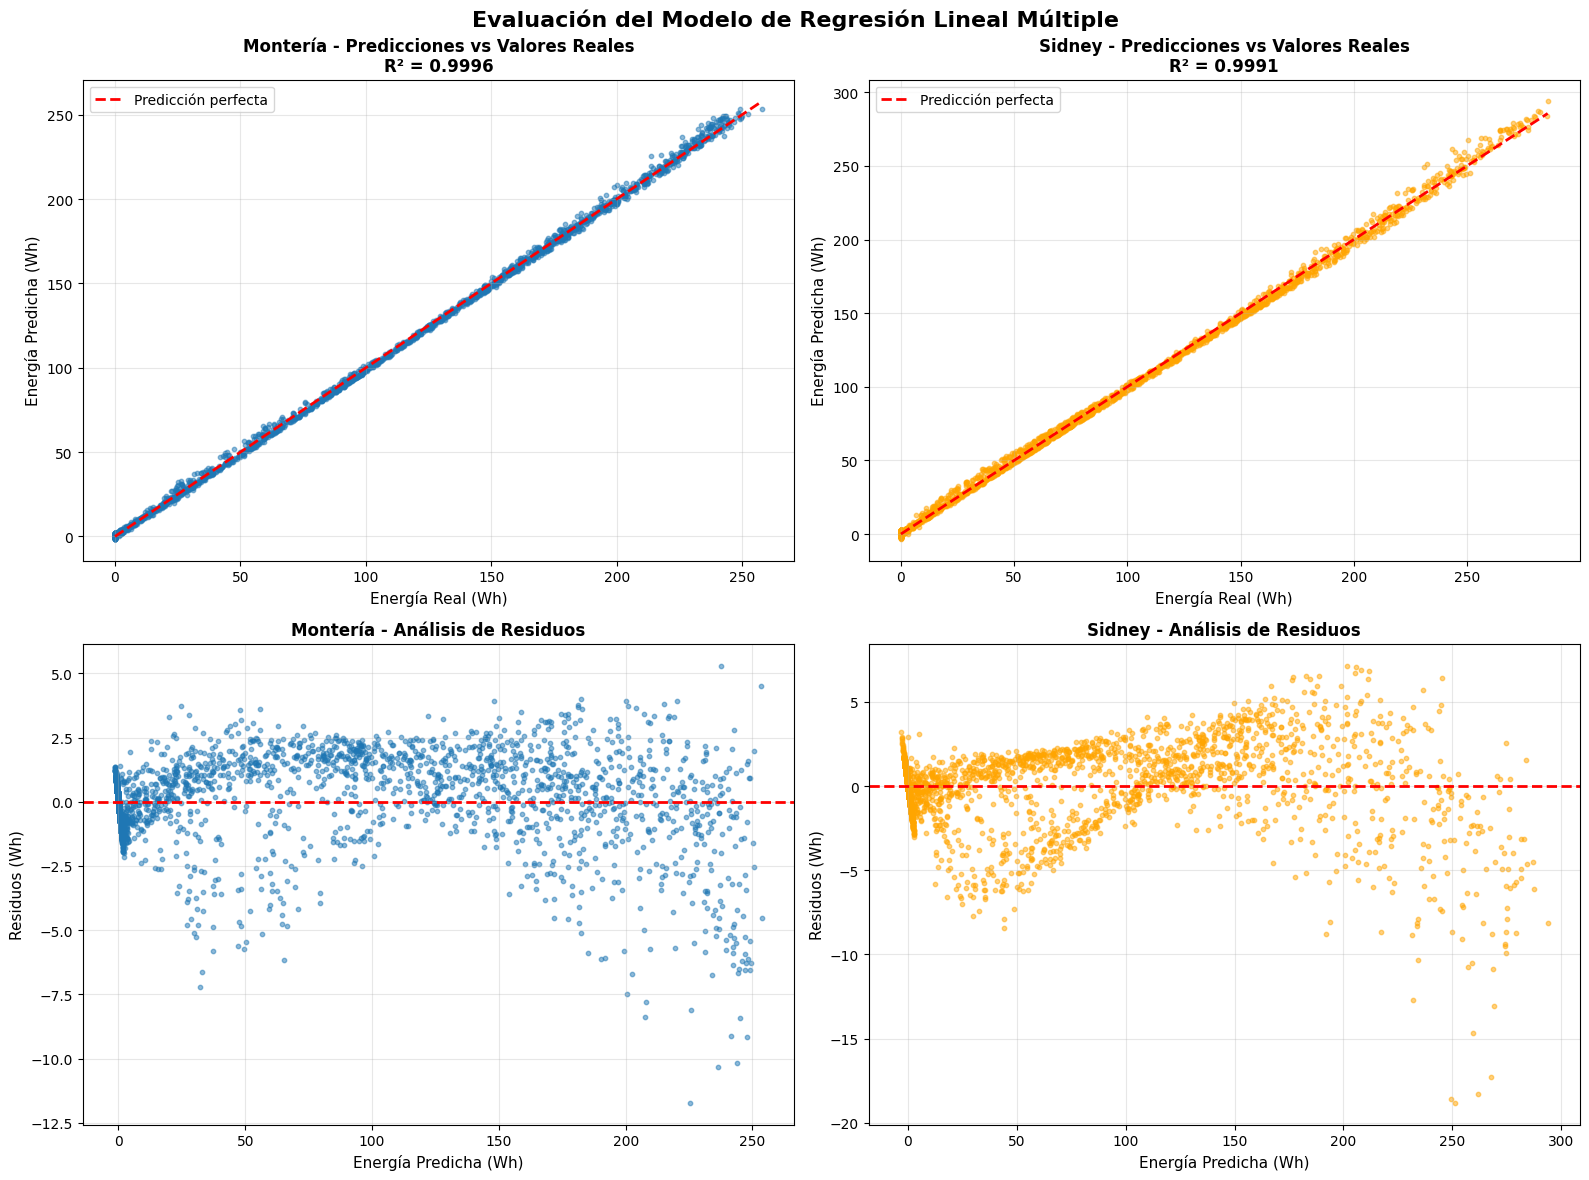

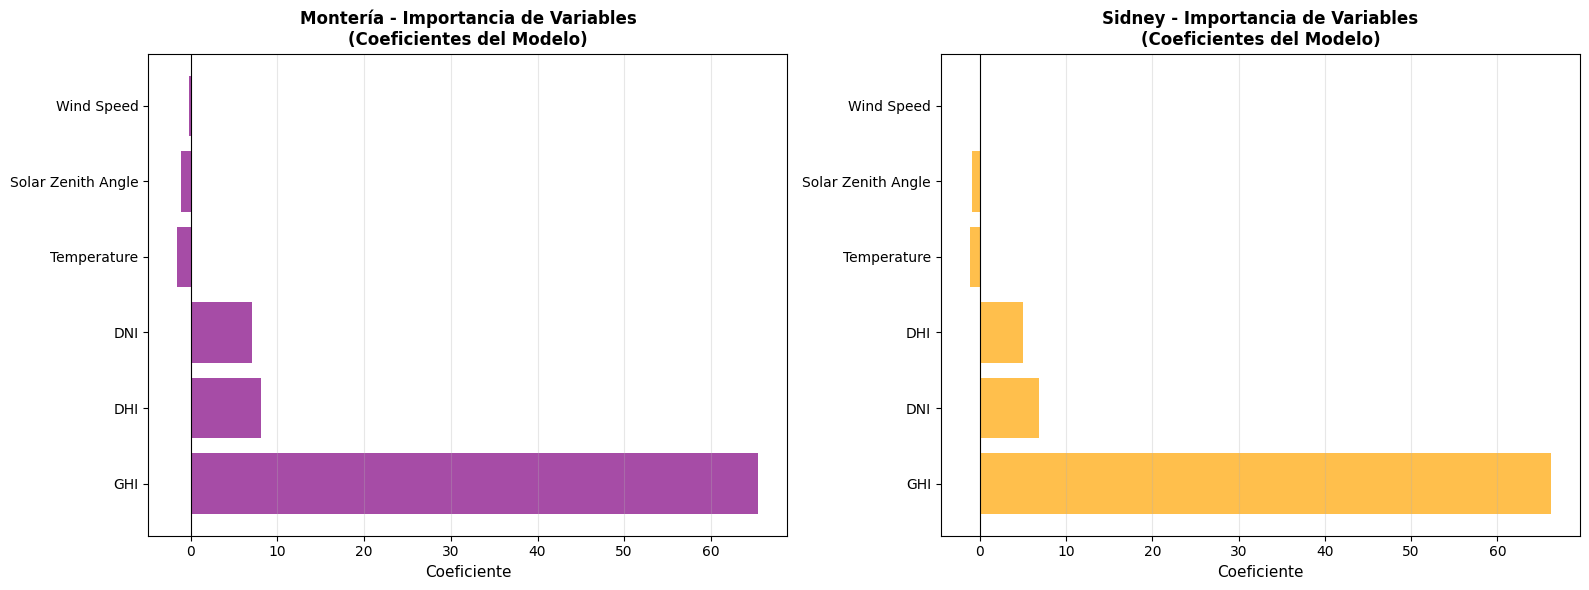

COMPARACIÓN FINAL Y CONCLUSIONES

🔍 ANÁLISIS COMPARATIVO:

1. PRECISIÓN DEL MODELO (R²):
   Montería: 0.999607 (99.96%)
   Sidney:   0.999133 (99.91%)
   → Mejor ajuste: Montería

2. ERROR ABSOLUTO MEDIO (MAE):
   Montería: 1.0459 Wh
   Sidney:   1.4721 Wh
   → Menor error: Montería

3. VARIABLES MÁS INFLUYENTES:

   Montería (por magnitud de coeficiente):
   1. GHI: +65.489174
   2. DHI: +8.134893
   3. DNI: +7.069276

   Sidney (por magnitud de coeficiente):
   1. GHI: +66.213507
   2. DNI: +6.846583
   3. DHI: +5.046678

4. DIFERENCIAS ENTRE MODELOS:
   Diferencia en R²:  0.000474
   Diferencia en MAE: 0.4263 Wh


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

print("CARGA Y PREPARACIÓN DE DATOS")

# Cargar datos (saltando las primeras 2 filas de metadatos)
df_monteria = pd.read_csv('Dataset_Monteria.csv', skiprows=2)
df_sidney = pd.read_csv('Dataset_Sidney.csv', skiprows=2)

# Crear columna de fecha completa
df_monteria['Fecha'] = pd.to_datetime(df_monteria[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_sidney['Fecha'] = pd.to_datetime(df_sidney[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Filtrar datos del año 2020
df_monteria_2020 = df_monteria[df_monteria['Year'] == 2020].copy()
df_sidney_2020 = df_sidney[df_sidney['Year'] == 2020].copy()

print(f"\n✓ Datos cargados correctamente:")
print(f"  - Montería 2020: {df_monteria_2020.shape[0]:,} registros")
print(f"  - Sidney 2020: {df_sidney_2020.shape[0]:,} registros")


print("CÁLCULO DE LA VARIABLE OBJETIVO")

class PanelSolarFotovoltaico:
    """
    Clase para simular un panel solar fotovoltaico.
    Modelo basado en ecuación: P = G × A × η × PR
    Referencias: Green (2019), Luque & Hegedus (2011)
    """
    def __init__(self, potencia_nominal, area, eficiencia_nominal,
                 coeficiente_temperatura, temperatura_noct, nombre="Panel Solar"):
        self.nombre = nombre
        self.potencia_nominal = potencia_nominal
        self.area = area
        self.eficiencia_nominal = eficiencia_nominal
        self.coeficiente_temperatura = coeficiente_temperatura
        self.temperatura_noct = temperatura_noct
        self.irradiancia_stc = 1000  # W/m²
        self.temperatura_stc = 25    # °C
        self.performance_ratio = 0.85

    def calcular_temperatura_celda(self, temperatura_ambiente, irradiancia):
        """Calcula la temperatura de la celda solar."""
        return temperatura_ambiente + ((self.temperatura_noct - 20) / 800) * irradiancia

    def calcular_eficiencia_real(self, temperatura_celda):
        """Calcula la eficiencia real corregida por temperatura."""
        delta_temperatura = temperatura_celda - self.temperatura_stc
        factor_temperatura = 1 + (self.coeficiente_temperatura / 100) * delta_temperatura
        return self.eficiencia_nominal * factor_temperatura

    def calcular_potencia_instantanea(self, irradiancia, temperatura_ambiente):
        """Calcula la potencia instantánea del panel (en Watts)."""
        temp_celda = self.calcular_temperatura_celda(temperatura_ambiente, irradiancia)
        eficiencia_real = self.calcular_eficiencia_real(temp_celda)
        potencia = irradiancia * self.area * eficiencia_real * self.performance_ratio
        return max(0, potencia)

# Crear instancia del panel
panel = PanelSolarFotovoltaico(
    potencia_nominal=300,
    area=1.95,
    eficiencia_nominal=0.184,
    coeficiente_temperatura=-0.41,
    temperatura_noct=45,
    nombre="Canadian Solar CS3K-300MS"
)

print(f"\n📋 Panel solar seleccionado: {panel.nombre}")
print(f"   Potencia nominal: {panel.potencia_nominal} W")
print(f"   Área: {panel.area} m²")
print(f"   Eficiencia: {panel.eficiencia_nominal*100:.1f}%")

# Calcular producción de energía para cada registro
def calcular_energia_producida(df, panel):
    """Calcula la energía producida (Wh) para cada registro horario."""
    energia = []
    for _, row in df.iterrows():
        potencia = panel.calcular_potencia_instantanea(row['GHI'], row['Temperature'])
        energia.append(potencia)  # Wh (potencia por 1 hora)
    return energia

print("\n⚙️  Calculando producción de energía para cada ubicación...")
df_monteria_2020['Energia_Producida'] = calcular_energia_producida(df_monteria_2020, panel)
df_sidney_2020['Energia_Producida'] = calcular_energia_producida(df_sidney_2020, panel)

print(f"✓ Variable objetivo 'Energia_Producida' creada exitosamente")
print(f"  Rango Montería: {df_monteria_2020['Energia_Producida'].min():.2f} - {df_monteria_2020['Energia_Producida'].max():.2f} Wh")
print(f"  Rango Sidney: {df_sidney_2020['Energia_Producida'].min():.2f} - {df_sidney_2020['Energia_Producida'].max():.2f} Wh")


print("SELECCIÓN DE VARIABLES PREDICTORAS")

# Variables independientes (features)
features = ['GHI', 'DNI', 'DHI', 'Temperature', 'Wind Speed', 'Solar Zenith Angle']
target = 'Energia_Producida'

print(f"\n📊 Variables seleccionadas para el modelo:")
for i, feature in enumerate(features, 1):
    print(f"  {i}. {feature}")
print(f"\n🎯 Variable objetivo: {target}")

# Preparar datos para Montería
X_monteria = df_monteria_2020[features].copy()
y_monteria = df_monteria_2020[target].copy()

# Preparar datos para Sidney
X_sidney = df_sidney_2020[features].copy()
y_sidney = df_sidney_2020[target].copy()


print("ANÁLISIS DE CORRELACIÓN")

# Matriz de correlación para Montería
df_corr_mont = X_monteria.copy()
df_corr_mont['Energia_Producida'] = y_monteria
correlation_mont = df_corr_mont.corr()

# Matriz de correlación para Sidney
df_corr_sidn = X_sidney.copy()
df_corr_sidn['Energia_Producida'] = y_sidney
correlation_sidn = df_corr_sidn.corr()

print("\n📈 Correlación con Energia_Producida:")
print("\nMontería:")
corr_mont_sorted = correlation_mont['Energia_Producida'].sort_values(ascending=False)
for var, corr in corr_mont_sorted.items():
    if var != 'Energia_Producida':
        print(f"  {var:25s}: {corr:+.4f}")

print("\nSidney:")
corr_sidn_sorted = correlation_sidn['Energia_Producida'].sort_values(ascending=False)
for var, corr in corr_sidn_sorted.items():
    if var != 'Energia_Producida':
        print(f"  {var:25s}: {corr:+.4f}")


print("DIVISIÓN DE DATOS (ENTRENAMIENTO/PRUEBA)")

# División 80% entrenamiento, 20% prueba
X_train_mont, X_test_mont, y_train_mont, y_test_mont = train_test_split(
    X_monteria, y_monteria, test_size=0.2, random_state=42
)

X_train_sidn, X_test_sidn, y_train_sidn, y_test_sidn = train_test_split(
    X_sidney, y_sidney, test_size=0.2, random_state=42
)

print(f"\n✓ División completada (80% entrenamiento, 20% prueba):")
print(f"\nMontería:")
print(f"  Entrenamiento: {len(X_train_mont):,} registros")
print(f"  Prueba: {len(X_test_mont):,} registros")
print(f"\nSidney:")
print(f"  Entrenamiento: {len(X_train_sidn):,} registros")
print(f"  Prueba: {len(X_test_sidn):,} registros")


print("ESCALADO DE VARIABLES PREDICTORAS")

# Escalar features
scaler_mont = StandardScaler()
X_train_mont_scaled = scaler_mont.fit_transform(X_train_mont)
X_test_mont_scaled = scaler_mont.transform(X_test_mont)

scaler_sidn = StandardScaler()
X_train_sidn_scaled = scaler_sidn.fit_transform(X_train_sidn)
X_test_sidn_scaled = scaler_sidn.transform(X_test_sidn)

print("\n✓ Variables predictoras escaladas exitosamente")


print("ENTRENAMIENTO DEL MODELO DE REGRESIÓN LINEAL MÚLTIPLE")

# Crear y entrenar modelos
modelo_monteria = LinearRegression()
modelo_sidney = LinearRegression()

print("\n⚙️  Entrenando modelos...")
modelo_monteria.fit(X_train_mont_scaled, y_train_mont)
modelo_sidney.fit(X_train_sidn_scaled, y_train_sidn)

print("✓ Modelos entrenados exitosamente")

# Mostrar coeficientes
print("\n📊 COEFICIENTES DEL MODELO:")
print("\nMontería:")
for feature, coef in zip(features, modelo_monteria.coef_):
    print(f"  {feature:25s}: {coef:+.6f}")

print("\nSidney:")
for feature, coef in zip(features, modelo_sidney.coef_):
    print(f"  {feature:25s}: {coef:+.6f}")


print("EVALUACIÓN DEL MODELO")

# Realizar predicciones en los conjuntos de entrenamiento y prueba escalados
y_pred_train_mont = modelo_monteria.predict(X_train_mont_scaled)
y_pred_test_mont = modelo_monteria.predict(X_test_mont_scaled)

y_pred_train_sidn = modelo_sidney.predict(X_train_sidn_scaled)
y_pred_test_sidn = modelo_sidney.predict(X_test_sidn_scaled)


def evaluar_modelo(y_real, y_pred, nombre_conjunto):
    """Calcula métricas de evaluación del modelo."""
    r2 = r2_score(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)

    return {
        'Conjunto': nombre_conjunto,
        'R²': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# Evaluar Montería
print("MONTERÍA")

metricas_train_mont = evaluar_modelo(y_train_mont, y_pred_train_mont, "Entrenamiento")
metricas_test_mont = evaluar_modelo(y_test_mont, y_pred_test_mont, "Prueba")

print(f"\n📊 Conjunto de Entrenamiento:")
print(f"  R² (Coeficiente de determinación): {metricas_train_mont['R²']:.6f}")
print(f"  MAE (Error Absoluto Medio):        {metricas_train_mont['MAE']:.4f} Wh")
print(f"  RMSE (Raíz del Error Cuadrático):  {metricas_train_mont['RMSE']:.4f} Wh")

print(f"\n📊 Conjunto de Prueba:")
print(f"  R² (Coeficiente de determinación): {metricas_test_mont['R²']:.6f}")
print(f"  MAE (Error Absoluto Medio):        {metricas_test_mont['MAE']:.4f} Wh")
print(f"  RMSE (Raíz del Error Cuadrático):  {metricas_test_mont['RMSE']:.4f} Wh")

# Evaluar Sidney
print("SIDNEY")

metricas_train_sidn = evaluar_modelo(y_train_sidn, y_pred_train_sidn, "Entrenamiento")
metricas_test_sidn = evaluar_modelo(y_test_sidn, y_pred_test_sidn, "Prueba")

print(f"\n Conjunto de Entrenamiento:")
print(f"  R² (Coeficiente de determinación): {metricas_train_sidn['R²']:.6f}")
print(f"  MAE (Error Absoluto Medio):        {metricas_train_sidn['MAE']:.4f} Wh")
print(f"  RMSE (Raíz del Error Cuadrático):  {metricas_train_sidn['RMSE']:.4f} Wh")

print(f"\n Conjunto de Prueba:")
print(f"  R² (Coeficiente de determinación): {metricas_test_sidn['R²']:.6f}")
print(f"  MAE (Error Absoluto Medio):        {metricas_test_sidn['MAE']:.4f} Wh")
print(f"  RMSE (Raíz del Error Cuadrático):  {metricas_test_sidn['RMSE']:.4f} Wh")

# Interpretación del R²
print("INTERPRETACIÓN DE MÉTRICAS")

print("\n R² (Coeficiente de Determinación):")
print("  - Rango: 0 a 1 (donde 1 es perfecto)")
print("  - Interpreta: % de variabilidad explicada por el modelo")
print(f"  - Montería: {metricas_test_mont['R²']*100:.2f}% de la variabilidad explicada")
print(f"  - Sidney: {metricas_test_sidn['R²']*100:.2f}% de la variabilidad explicada")

mejor_r2 = "Sidney" if metricas_test_sidn['R²'] > metricas_test_mont['R²'] else "Montería"
print(f"   → Mejor ajuste: {mejor_r2}")

print("\n MAE (Error Absoluto Medio):")
print("  - Interpreta: error promedio en unidades originales (Wh)")
print(f"  - Montería: error promedio de {metricas_test_mont['MAE']:.2f} Wh")
print(f"  - Sidney: error promedio de {metricas_test_sidn['MAE']:.2f} Wh")

mejor_mae = "Sidney" if metricas_test_sidn['MAE'] < metricas_test_mont['MAE'] else "Montería"
print(f"   → Menor error: {mejor_mae}")

print("\n RMSE (Raíz del Error Cuadrático Medio):")
print("  - Interpreta: penaliza más los errores grandes")
print(f"  - Montería: {metricas_test_mont['RMSE']:.2f} Wh")
print(f"  - Sidney: {metricas_test_sidn['RMSE']:.2f} Wh")


print("VISUALIZACIONES")

# Gráfica 1: Valores Reales vs Predichos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evaluación del Modelo de Regresión Lineal Múltiple',
             fontsize=16, fontweight='bold')

# Montería - Scatter plot
ax1 = axes[0, 0]
ax1.scatter(y_test_mont, y_pred_test_mont, alpha=0.5, s=10)
ax1.plot([y_test_mont.min(), y_test_mont.max()],
         [y_test_mont.min(), y_test_mont.max()],
         'r--', lw=2, label='Predicción perfecta')
ax1.set_xlabel('Energía Real (Wh)', fontsize=11)
ax1.set_ylabel('Energía Predicha (Wh)', fontsize=11)
ax1.set_title(f'Montería - Predicciones vs Valores Reales\nR² = {metricas_test_mont["R²"]:.4f}',
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sidney - Scatter plot
ax2 = axes[0, 1]
ax2.scatter(y_test_sidn, y_pred_test_sidn, alpha=0.5, s=10, color='orange')
ax2.plot([y_test_sidn.min(), y_test_sidn.max()],
         [y_test_sidn.min(), y_test_sidn.max()],
         'r--', lw=2, label='Predicción perfecta')
ax2.set_xlabel('Energía Real (Wh)', fontsize=11)
ax2.set_ylabel('Energía Predicha (Wh)', fontsize=11)
ax2.set_title(f'Sidney - Predicciones vs Valores Reales\nR² = {metricas_test_sidn["R²"]:.4f}',
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Montería - Residuos
ax3 = axes[1, 0]
residuos_mont = y_test_mont - y_pred_test_mont
ax3.scatter(y_pred_test_mont, residuos_mont, alpha=0.5, s=10)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Energía Predicha (Wh)', fontsize=11)
ax3.set_ylabel('Residuos (Wh)', fontsize=11)
ax3.set_title('Montería - Análisis de Residuos', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Sidney - Residuos
ax4 = axes[1, 1]
residuos_sidn = y_test_sidn - y_pred_test_sidn
ax4.scatter(y_pred_test_sidn, residuos_sidn, alpha=0.5, s=10, color='orange')
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Energía Predicha (Wh)', fontsize=11)
ax4.set_ylabel('Residuos (Wh)', fontsize=11)
ax4.set_title('Sidney - Análisis de Residuos', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfica 2: Comparación de Coeficientes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Montería
coef_mont_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': modelo_monteria.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

ax1.barh(coef_mont_df['Variable'], coef_mont_df['Coeficiente'], color='purple', alpha=0.7)
ax1.set_xlabel('Coeficiente', fontsize=11)
ax1.set_title('Montería - Importancia de Variables\n(Coeficientes del Modelo)',
              fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# Sidney
coef_sidn_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': modelo_sidney.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

ax2.barh(coef_sidn_df['Variable'], coef_sidn_df['Coeficiente'], color='orange', alpha=0.7)
ax2.set_xlabel('Coeficiente', fontsize=11)
ax2.set_title('Sidney - Importancia de Variables\n(Coeficientes del Modelo)',
              fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


print("COMPARACIÓN FINAL Y CONCLUSIONES")

print("\n🔍 ANÁLISIS COMPARATIVO:")
print("\n1. PRECISIÓN DEL MODELO (R²):")
print(f"   Montería: {metricas_test_mont['R²']:.6f} ({metricas_test_mont['R²']*100:.2f}%)")
print(f"   Sidney:   {metricas_test_sidn['R²']:.6f} ({metricas_test_sidn['R²']*100:.2f}%)")
mejor_r2 = "Sidney" if metricas_test_sidn['R²'] > metricas_test_mont['R²'] else "Montería"
print(f"   → Mejor ajuste: {mejor_r2}")

print("\n2. ERROR ABSOLUTO MEDIO (MAE):")
print(f"   Montería: {metricas_test_mont['MAE']:.4f} Wh")
print(f"   Sidney:   {metricas_test_sidn['MAE']:.4f} Wh")
mejor_mae = "Sidney" if metricas_test_sidn['MAE'] < metricas_test_mont['MAE'] else "Montería"
print(f"   → Menor error: {mejor_mae}")

print("\n3. VARIABLES MÁS INFLUYENTES:")
print("\n   Montería (por magnitud de coeficiente):")
for i, (var, coef) in enumerate(zip(coef_mont_df['Variable'][:3], coef_mont_df['Coeficiente'][:3]), 1):
    print(f"   {i}. {var}: {coef:+.6f}")

print("\n   Sidney (por magnitud de coeficiente):")
for i, (var, coef) in enumerate(zip(coef_sidn_df['Variable'][:3], coef_sidn_df['Coeficiente'][:3]), 1):
    print(f"   {i}. {var}: {coef:+.6f}")

print("\n4. DIFERENCIAS ENTRE MODELOS:")
diff_r2 = abs(metricas_test_mont['R²'] - metricas_test_sidn['R²'])
diff_mae = abs(metricas_test_mont['MAE'] - metricas_test_sidn['MAE'])
print(f"   Diferencia en R²:  {diff_r2:.6f}")
print(f"   Diferencia en MAE: {diff_mae:.4f} Wh")